---
## Real data
### Period 
1983-2018
### Output gap
Beveridge-Nelson Filter (https://bnfiltering.com)

### Inflation Expectation
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)
### Inflation rate
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

---

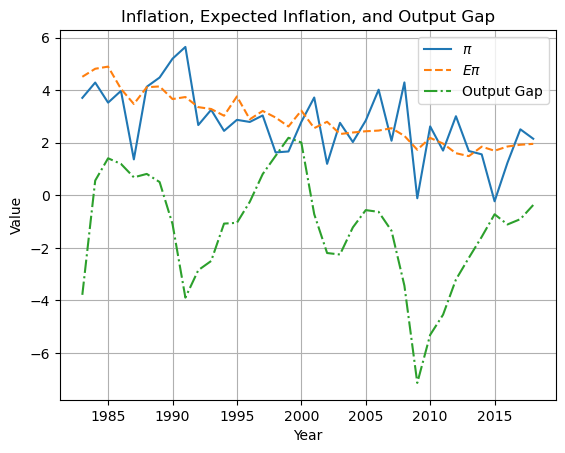

In [26]:
import pandas as pd
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
from pymc.pytensorf import collect_default_updates
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import display, Math
import warnings
warnings.simplefilter('ignore')

data_cpi = pd.read_csv("data/CPIAUCSL.csv")
data_cpi['month'] = pd.to_datetime(data_cpi['DATE']).dt.month
data_cpi = data_cpi[data_cpi['month'] == 1]
data_cpi['year'] = pd.to_datetime(data_cpi['DATE']).dt.year
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi[['year', 'pi']]

data_gap = pd.read_csv("data/BN_filter_GDPC1_annual.csv")
data_gap['year'] = pd.to_datetime(data_gap['date']).dt.year
data_gap['gap'] = data_gap["cycle"]
data_gap = data_gap[["year", "gap"]]

data_Epi = pd.read_csv("data/inflation_expectations_monthly.csv")
data_Epi['month'] = pd.to_datetime(data_Epi['DateTime']).dt.month
data_Epi = data_Epi[data_Epi['month'] == 1]
data_Epi['year'] = pd.to_datetime(data_Epi['DateTime']).dt.year
data_Epi['Epi'] = data_Epi['expected_inflation']
data_Epi = data_Epi[['year', 'Epi']]

data = pd.merge(data_gap, data_Epi, on='year', how='inner')
data = pd.merge(data, data_cpi, on='year', how='inner')
data = data[data['year'] < 2019]
data["pi_t-1"] = data["pi"].shift(1)
data = data[data['year'] > 1982]
# Convert each pandas Series to lists
pi = data["pi"].tolist()
pi_t_1 = data["pi_t-1"].tolist()
Epi = data["Epi"].tolist()
gap = data["gap"].tolist()
year = data["year"].tolist()
T = len(year)


plt.plot(year, data["pi"], label=r'$\pi$', linestyle='-')       
plt.plot(year, data["Epi"], label=r'$E\pi$', linestyle='--')    
plt.plot(year, data["gap"], label='Output Gap', linestyle='-.') 

plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Inflation, Expected Inflation, and Output Gap')
plt.legend()
plt.grid()
plt.show()

### Model 1: 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - z_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

$$
z_t =  \rho z_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$

### Model 2:
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - z_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

$$
z_t =  \rho z_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$

In [13]:
# Define the model
with pm.Model() as model_1:
    # Parameters
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=1)
    sigma_kappa = pm.HalfNormal('sigma_kappa', sigma=1)   
    sigma_rho = pm.HalfNormal('sigma_rho', sigma=1)   
    beta  = pm.Normal('beta', mu=1, sigma=sigma_beta)
    kappa = pm.HalfNormal('kappa', sigma=sigma_kappa)
    rho   = pm.Normal('rho', mu=0 , sigma=sigma_rho)

    # Latent variable
    init = pm.Normal.dist(1, size=1)
    sigma_eta = pm.HalfNormal('sigma_eta', sigma=1)
    z = pm.AR('z', rho, sigma=sigma_eta, shape=T, init_dist=init)

    # Observation model
    sigma_e = pm.HalfNormal('sigma_e', sigma=1)
    pi_obs = pm.Normal('pi_obs', mu=beta * Epi + kappa * gap - z, sigma=sigma_e, observed=pi)

# Define the model
with pm.Model() as model_2:
    # Parameters
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=1)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=1)
    sigma_kappa = pm.HalfNormal('sigma_kappa', sigma=1)
    sigma_rho = pm.HalfNormal('sigma_rho', sigma=1)    
    alpha = pm.Normal('alpha', mu=1, sigma=sigma_alpha)
    beta = pm.Normal('beta', mu=1, sigma=sigma_beta)
    kappa = pm.HalfNormal('kappa', sigma=sigma_kappa)
    rho = pm.Normal('rho', mu=0, sigma=sigma_rho)

    # Latent variable
    sigma_eta = pm.HalfNormal('sigma_eta', sigma=1)
    init = pm.Normal.dist(1, size=1)
    z = pm.AR('z', rho, sigma=sigma_eta, shape=T, init_dist=init)
    # Observation model
    sigma_e = pm.HalfNormal('sigma_e', sigma=1)
    pi_obs = pm.Normal('pi_obs', mu=alpha * pi_t_1 + beta * Epi + kappa * gap - z, sigma=sigma_e, observed=pi)

### Model 3: 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - z_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

$$
z_t =  \rho_{1} z_{t-1} +  \rho_{2} \pi_{t-1} + \rho_{3} \hat{Y}_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$

### Model 4: 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - z_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

$$
z_t =  \rho_{1} z_{t-1} +  \rho_{2} \pi_{t-1} + \rho_{3} \hat{Y}_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$

In [ ]:
# Define the model
with pm.Model() as model_3:
    # Prior distributions
    # standard errors
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=1)
    sigma_kappa = pm.HalfNormal('sigma_kappa', sigma=1)   
    sigma_rho_1 = pm.HalfNormal('sigma_rho_1', sigma=1)
    sigma_rho_2 = pm.HalfNormal('sigma_rho_2', sigma=1)
    sigma_rho_3 = pm.HalfNormal('sigma_rho_3', sigma=1)

    sigma_eta = pm.HalfNormal('sigma_eta', sigma=1)
    sigma_e = pm.HalfNormal('sigma_e', sigma=1)
    
    # Parameters
    beta  = pm.Normal('beta', mu=1, sigma=sigma_beta)
    kappa = pm.HalfNormal('kappa', sigma=sigma_kappa)
    rho_1   = pm.Normal('rho_1', mu=0 , sigma=sigma_rho_1)
    rho_2   = pm.Normal('rho_2', mu=0 , sigma=sigma_rho_2)
    rho_3   = pm.Normal('rho_3', mu=0 , sigma=sigma_rho_3)

    # Latent variable
    z_init = pm.Normal('z_init', mu=0, sigma=1)
    
    
    # Observation model
    pi_obs = pm.Normal('pi_obs', mu=beta * Epi + kappa * gap - z, sigma=sigma_e, observed=pi)

# Define the model
with pm.Model() as model_4:
    # Prior distributions
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=1)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=1)
    sigma_kappa = pm.HalfNormal('sigma_kappa', sigma=1)
    sigma_rho = pm.HalfNormal('sigma_rho', sigma=1)    

    sigma_eta = pm.HalfNormal('sigma_eta', sigma=1)
    sigma_e = pm.HalfNormal('sigma_e', sigma=1)
    
    # Parameters
    alpha = pm.Normal('alpha', mu=1, sigma=sigma_alpha)
    beta = pm.Normal('beta', mu=1, sigma=sigma_beta)
    kappa = pm.HalfNormal('kappa', sigma=sigma_kappa)
    rho = pm.Normal('rho', mu=0, sigma=sigma_rho)

    # Latent variable
    init = pm.Normal.dist(1, size=1)
    z = pm.AR('z', rho, sigma=sigma_eta, shape=T, init_dist=init)
    # Observation model
    pi_obs = pm.Normal('pi_obs', mu=alpha * pi_t_1 + beta * Epi + kappa * gap - z, sigma=sigma_e, observed=pi)

####  Model of "COMPETITION AND THE PHILLIPS CURVE"
Ippei Fujiwara and Kiminori Matsuyama

NKPC in terms of the output gap is given by:

$$
\hat{\pi}_t 
= \beta E_t[\hat{\pi}_{t+1}]
  \;+\;\kappa(z)\,\hat{Y}_t
  \;-\;\frac{\zeta(z) - 1}{\chi}\,\frac{1 - \rho(z)}{\rho(z)}\,\hat{z}_t,
$$

where

$$
\kappa(z)
:= \frac{\zeta(z) - 1}{\chi}
   \,\frac{1}{1 + \psi}
   \,\frac{
       (\sigma + \psi)
       \;-\;\bigl(1 - \sigma\bigr)\,\dfrac{1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }{
       1
       \;-\;\dfrac{\zeta(z) - 1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }.
$$
---
####  Estimated State-Space model

The observed variable $\pi_t$ is the inflation rate, $\text{E}\pi_t$ is the expected inflation rate, and $\text{gap}_t$ is the output gap:

---
1. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - z_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

$$
z_t =  \rho z_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
---
2. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - z_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

$$
z_t =  \rho z_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
---
3. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - z_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

$$
z_t =  \rho_{1} z_{t-1} +  \rho_{2} \pi_{t-1} + \rho_{3} \hat{Y}_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$

---
4. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - z_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

$$
z_t =  \rho_{1} z_{t-1} +  \rho_{2} \pi_{t-1} + \rho_{3} \hat{Y}_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$